In [1]:
import numpy as np
from sklearn.metrics import classification_report
from load_data import *
import scipy
import sklearn
import matplotlib.pyplot as plt
from pathlib import Path

In [9]:
TRAIN_PATH = './snips/snips_train_actual.csv'
TEST_PATH = './snips/snips_test_actual.csv'

In [10]:
data_loader = DataLoader(TRAIN_PATH, None, TEST_PATH)
data_loader.split_train_valid(valid_size=0.05, keep_class_ratios=True)

In [11]:
X_train, y_train = data_loader.get_train_data()
X_valid, y_valid = data_loader.get_valid_data()

In [12]:
feature_extractor = FeatureExtractor(X_train, X_valid)
feature_extractor.extract_features(keep_words_threshold=5)
X_train = feature_extractor.get_train_encodings()
X_valid = feature_extractor.get_valid_encodings()

In [2]:
class SoftmaxRegression():
    def __init__(self, training_rate, num_iter):
        self.training_rate = training_rate
        self.num_iter = num_iter
        pass
    
    """
    fit(self, X, y): fits the weights and biases based on X (training set design matrix) and y (training set ground truths).
    Input: X -- (num_examples, vocab_size) shape.
    Input: y -- (num_examples, ) shape.
    """
    def fit(self, X, y, X_val, y_val):
        num_examples, vocab_size = X.shape
        num_labels = np.amax(y) + 1
        y_one_hot = np.eye(num_labels)[y].T
        y_val_one_hot = np.eye(num_labels)[y_val].T
        
        self.weights = np.random.normal(loc=0.0, scale=(1/np.sqrt(X.shape[0])), size=(num_labels, vocab_size))
        self.biases = np.zeros((num_labels,1))
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        train_F1s = []
        val_F1s = []
        
        for i in range(self.num_iter):
            # Training
            predictions = self.predict(X)
            self.weights = self.weights - self.training_rate * np.dot(predictions - y_one_hot, X)
            self.biases = self.biases - self.training_rate * np.reshape(np.sum(predictions - y_one_hot, axis=1), (-1, 1))
            
            # Metrics
            predictions_train = self.predict(X)
            predictions_val = self.predict(X_val)
            train_loss = self.get_loss(predictions_train, y_one_hot)
            val_loss = self.get_loss(predictions_val, y_val_one_hot)
            train_accuracy = self.find_accuracy(predictions_train, y)
            val_accuracy = self.find_accuracy(predictions_val, y_val)
            
            f1_score_train = sklearn.metrics.f1_score(y, np.argmax(predictions_train, axis=0), average = 'weighted')
            f1_score_val = sklearn.metrics.f1_score(y_val, np.argmax(predictions_val, axis=0), average = 'weighted')
            
            if(i%5 == 0):
                print("Iteration %d: train_loss: %f, val_loss: %f, train_accuracy: %f, val_accuracy: %f, train_f1: %f, val_f1: %f"%(i, train_loss, val_loss, train_accuracy, val_accuracy, f1_score_train, f1_score_val))   
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            train_F1s.append(f1_score_train)
            val_F1s.append(f1_score_val)
            
        history = (train_losses, val_losses, train_accuracies, val_accuracies, train_F1s, val_F1s)
        return history
        
        
            
        
    """
    predict(self, X): Returns predictions of the labels given the design matrix X.
    Input: X -- (num_examples, vocab_size) shape.
    Output: predictions -- (num_labels, num_examples) shape.
    """
    def predict(self, X):
        return scipy.special.softmax(np.dot(self.weights, X.T) + self.biases, axis=0)
    
    """
    get_loss(self, X, y): Returns the loss.
    Input: predictions -- (num_examples, num_labels) shape.
    Input: y -- (num_examples, num_labels) shape. (has to be one-hot)
    Output: loss -- scalar.
    """
    def get_loss(self, predictions, y):
        return -np.average(np.sum(np.multiply(y, np.log(predictions)), axis=0))
    
    """
    find_accuracy(self, predictions, y): returns the accuracy
    Input: predictions -- (num_examples, num_labels) shape.
    Input: y -- (num_examples, num_labels) shape. (has to be one-hot)
    Output: loss -- scalar.
    """
    def find_accuracy(self, predictions, y):
        predictions = np.argmax(predictions, axis=0)
        return np.average(predictions==y)
    
        

In [41]:
sr = SoftmaxRegression(0.001, 100)
history = sr.fit(X_train, y_train, X_valid, y_valid)

Iteration 0: train_loss: 0.651897, val_loss: 0.652126, train_accuracy: 0.857874, val_accuracy: 0.839130, train_f1: 0.857414, val_f1: 0.837410
Iteration 5: train_loss: 0.331289, val_loss: 0.342462, train_accuracy: 0.903773, val_accuracy: 0.904348, train_f1: 0.904767, val_f1: 0.903118
Iteration 10: train_loss: 0.182111, val_loss: 0.184914, train_accuracy: 0.960287, val_accuracy: 0.962319, train_f1: 0.960158, val_f1: 0.962246
Iteration 15: train_loss: 0.154550, val_loss: 0.157322, train_accuracy: 0.965557, val_accuracy: 0.966667, train_f1: 0.965532, val_f1: 0.966632
Iteration 20: train_loss: 0.137120, val_loss: 0.140173, train_accuracy: 0.968230, val_accuracy: 0.971014, train_f1: 0.968217, val_f1: 0.970899
Iteration 25: train_loss: 0.124759, val_loss: 0.128153, train_accuracy: 0.971208, val_accuracy: 0.972464, train_f1: 0.971185, val_f1: 0.972389
Iteration 30: train_loss: 0.115403, val_loss: 0.119153, train_accuracy: 0.973270, val_accuracy: 0.973913, train_f1: 0.973249, val_f1: 0.973772
I

In [35]:
class Plotter():
    def __init__(self, history):
        self.train_losses = history[0]
        self.val_losses = history[1]
        self.train_accuracies = history[2]
        self.val_accuracies = history[3]
        self.train_F1s = history[4]
        self.val_F1s = history[5]
    
    """
    Input: plot_content is one of ("Loss", "Accuracy", "F1")
    """
    def plot(self, plot_content):
        if(plot_content == "Loss"):
            plt.plot(range(len(self.train_losses)), self.train_losses, label = "Training Loss")
            plt.plot(range(len(self.val_losses)), self.val_losses, label = "Validation Loss")
            plt.ylabel('Loss')
            plt.title('Training and Validation Losses')
        elif(plot_content == "Accuracy"):
            plt.plot(range(len(self.train_accuracies)), self.train_accuracies, label = "Training Accuracy")
            plt.plot(range(len(self.val_accuracies)), self.val_accuracies, label = "Validation Accuracy")
            plt.ylabel('Accuracy')
            plt.title('Training and Validation Accuracies')
        elif(plot_content == "F1"):
            plt.plot(range(len(self.train_F1s)), self.train_F1s, label = "Training F1 Score")
            plt.plot(range(len(self.val_F1s)), self.val_F1s, label = "Validation F1 Score")
            plt.ylabel('F1 Score')
            plt.title('Training and Validation F1 Scores')
        plt.xlabel('Iteration')
        plt.legend()
        plt.show()
        

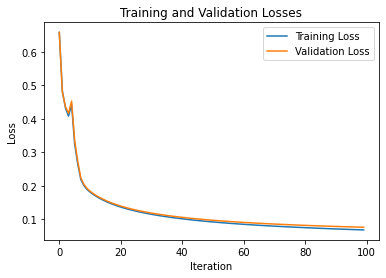

In [36]:
pl = Plotter(history)
pl.plot("Loss")

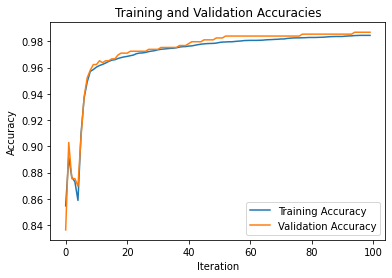

In [37]:
pl.plot("Accuracy")

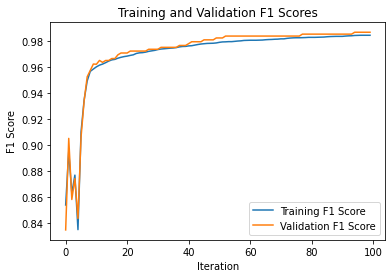

In [38]:
pl.plot("F1")

## BERT

In [3]:
def train_softmax_regression(config):
    save_dir = Path('embeddings/snips_word2vec_encodings')
    save_dir = save_dir / config
    X_train = np.load(save_dir / 'X_train.npy')
    y_train = np.load(save_dir / 'y_train.npy')
    X_valid = np.load(save_dir / 'X_valid.npy')
    y_valid = np.load(save_dir / 'y_valid.npy')
    X_test = np.load(save_dir / 'X_test.npy')
    y_test = np.load(save_dir / 'y_test.npy')
    
    print(config)
    sr = SoftmaxRegression(0.001, 200)
    history = sr.fit(X_train, y_train, X_valid, y_valid)
    print()
    print()

In [4]:
for config in GENSIM_PRETRAINED_MODELS:
    try:
        train_softmax_regression(config)
    except:
        continue

glove-wiki-gigaword-200
Iteration 0: train_loss: 1.232578, val_loss: 1.243313, train_accuracy: 0.595616, val_accuracy: 0.582609, train_f1: 0.566433, val_f1: 0.548083
Iteration 5: train_loss: 33.678065, val_loss: 33.823867, train_accuracy: 0.290667, val_accuracy: 0.292754, train_f1: 0.141994, val_f1: 0.144970
Iteration 10: train_loss: 31.506474, val_loss: 31.894416, train_accuracy: 0.324423, val_accuracy: 0.320290, train_f1: 0.232268, val_f1: 0.229384
Iteration 15: train_loss: 5.201713, val_loss: 5.228057, train_accuracy: 0.659844, val_accuracy: 0.646377, train_f1: 0.568695, val_f1: 0.560516
Iteration 20: train_loss: 0.516077, val_loss: 0.539644, train_accuracy: 0.899420, val_accuracy: 0.894203, train_f1: 0.899558, val_f1: 0.894194
Iteration 25: train_loss: 3.165580, val_loss: 3.302561, train_accuracy: 0.777150, val_accuracy: 0.763768, train_f1: 0.758005, val_f1: 0.743654
Iteration 30: train_loss: 0.348349, val_loss: 0.388096, train_accuracy: 0.930808, val_accuracy: 0.927536, train_f1: 